# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


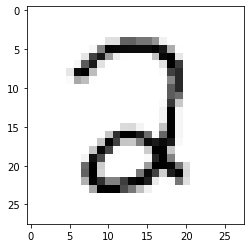

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2321
Training Accuracy: 0.7187, Testing Accuracy: 0.7273



Epoch 10, Loss 0.0793
Training Accuracy: 0.9213, Testing Accuracy: 0.9340



Epoch 20, Loss 0.0514
Training Accuracy: 0.9454, Testing Accuracy: 0.9546



Epoch 30, Loss 0.0414
Training Accuracy: 0.9530, Testing Accuracy: 0.9627



Epoch 40, Loss 0.0363
Training Accuracy: 0.9584, Testing Accuracy: 0.9667



Epoch 50, Loss 0.033
Training Accuracy: 0.9617, Testing Accuracy: 0.9682



Epoch 60, Loss 0.0307
Training Accuracy: 0.9644, Testing Accuracy: 0.9693



Epoch 70, Loss 0.029
Training Accuracy: 0.9657, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0276
Training Accuracy: 0.9673, Testing Accuracy: 0.9708



Epoch 90, Loss 0.0264
Training Accuracy: 0.9689, Testing Accuracy: 0.9718



Epoch 100, Loss 0.0254
Training Accuracy: 0.9705, Testing Accuracy: 0.9713



Epoch 110, Loss 0.0245
Training Accuracy: 0.9717, Testing Accuracy: 0.9728



Epoch 120, Loss 0.0238
Training Accuracy: 0.9732, Testing Accuracy: 0.9738



Epoch 130, Loss 0.0231
Training Accuracy: 0.9742, Testing Accuracy: 0.9738



Epoch 140, Loss 0.0224
Training Accuracy: 0.9751, Testing Accuracy: 0.9738



Epoch 150, Loss 0.0219
Training Accuracy: 0.9755, Testing Accuracy: 0.9733



Epoch 160, Loss 0.0213
Training Accuracy: 0.9755, Testing Accuracy: 0.9738



Epoch 170, Loss 0.0208
Training Accuracy: 0.9755, Testing Accuracy: 0.9743



Epoch 180, Loss 0.0203
Training Accuracy: 0.9763, Testing Accuracy: 0.9748



Epoch 190, Loss 0.0199
Training Accuracy: 0.9770, Testing Accuracy: 0.9753



Epoch 200, Loss 0.0195
Training Accuracy: 0.9781, Testing Accuracy: 0.9753



Epoch 210, Loss 0.019
Training Accuracy: 0.9784, Testing Accuracy: 0.9758



Epoch 220, Loss 0.0186
Training Accuracy: 0.9787, Testing Accuracy: 0.9758



Epoch 230, Loss 0.0183
Training Accuracy: 0.9796, Testing Accuracy: 0.9758



Epoch 240, Loss 0.0179
Training Accuracy: 0.9804, Testing Accuracy: 0.9758



0.004653922432487083

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.24
Training Accuracy: 0.6660, Testing Accuracy: 0.6512



Epoch 10, Loss 0.1026
Training Accuracy: 0.9115, Testing Accuracy: 0.9189



Epoch 20, Loss 0.0779
Training Accuracy: 0.9341, Testing Accuracy: 0.9415



Epoch 30, Loss 0.0669
Training Accuracy: 0.9414, Testing Accuracy: 0.9516



Epoch 40, Loss 0.0604
Training Accuracy: 0.9452, Testing Accuracy: 0.9551



Epoch 50, Loss 0.056
Training Accuracy: 0.9483, Testing Accuracy: 0.9577



Epoch 60, Loss 0.0528
Training Accuracy: 0.9507, Testing Accuracy: 0.9592



Epoch 70, Loss 0.0504
Training Accuracy: 0.9513, Testing Accuracy: 0.9597



Epoch 80, Loss 0.0484
Training Accuracy: 0.9527, Testing Accuracy: 0.9612



Epoch 90, Loss 0.0468
Training Accuracy: 0.9535, Testing Accuracy: 0.9632



Epoch 100, Loss 0.0454
Training Accuracy: 0.9538, Testing Accuracy: 0.9657



Epoch 110, Loss 0.0442
Training Accuracy: 0.9552, Testing Accuracy: 0.9662



Epoch 120, Loss 0.0432
Training Accuracy: 0.9561, Testing Accuracy: 0.9667



Epoch 130, Loss 0.0423
Training Accuracy: 0.9566, Testing Accuracy: 0.9667



Epoch 140, Loss 0.0415
Training Accuracy: 0.9574, Testing Accuracy: 0.9672



Epoch 150, Loss 0.0408
Training Accuracy: 0.9580, Testing Accuracy: 0.9672



Epoch 160, Loss 0.0402
Training Accuracy: 0.9586, Testing Accuracy: 0.9672



Epoch 170, Loss 0.0396
Training Accuracy: 0.9589, Testing Accuracy: 0.9682



Epoch 180, Loss 0.039
Training Accuracy: 0.9593, Testing Accuracy: 0.9688



Epoch 190, Loss 0.0385
Training Accuracy: 0.9595, Testing Accuracy: 0.9688



Epoch 200, Loss 0.0381
Training Accuracy: 0.9594, Testing Accuracy: 0.9688



Epoch 210, Loss 0.0376
Training Accuracy: 0.9604, Testing Accuracy: 0.9688



Epoch 220, Loss 0.0373
Training Accuracy: 0.9605, Testing Accuracy: 0.9688



Epoch 230, Loss 0.0369
Training Accuracy: 0.9613, Testing Accuracy: 0.9688



Epoch 240, Loss 0.0365
Training Accuracy: 0.9616, Testing Accuracy: 0.9682



0.06814204996376928

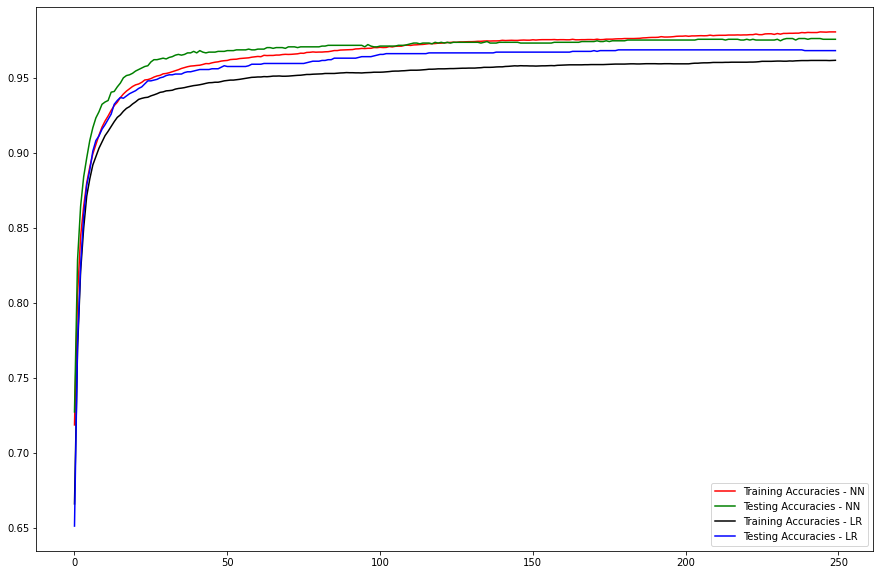

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

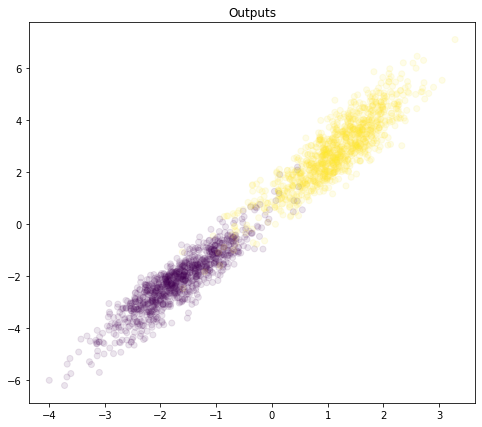

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

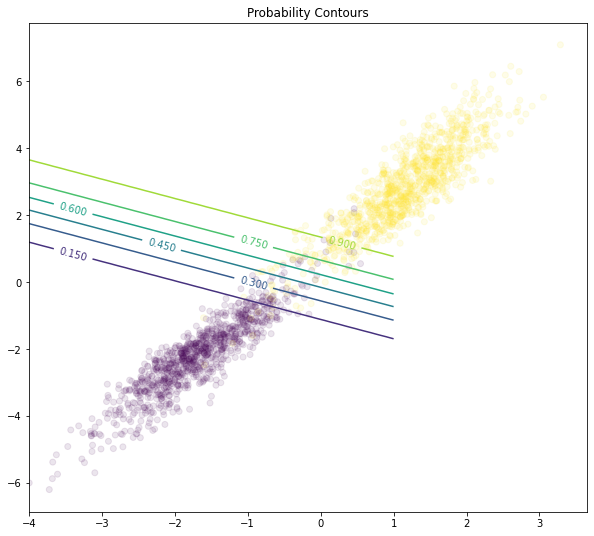

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );